In [1]:
import pandas as pd
from statsmodels.formula.api import ols as sm_ols
import numpy as np
import seaborn as sns


In [2]:
url = 'https://github.com/LeDataSciFi/ledatascifi-2021/blob/main/data/Fannie_Mae_Plus_Data.gzip?raw=true'
fannie_mae = pd.read_csv(url,compression='gzip') 

## Clean the data and create variables you want

In [3]:
fannie_mae = (fannie_mae
                  # create variables
                  .assign(l_credscore = np.log(fannie_mae['Borrower_Credit_Score_at_Origination']),
                          l_LTV = np.log(fannie_mae['Original_LTV_(OLTV)']),
                          Origination_Date = lambda x: pd.to_datetime(x['Origination_Date']),
                          Origination_Year = lambda x: x['Origination_Date'].dt.year,
                          const = 1
                         )
              
             )

# create a categorical credit bin var with "pd.cut()"
fannie_mae['creditbins']= pd.cut(fannie_mae['Co-borrower_credit_score_at_origination'],
                                 [0,579,669,739,799,850],
                                 labels=['Very Poor','Fair','Good','Very Good','Exceptional'])


## Statsmodels

Psuedocode:
```python
model = sm_ols(<formula>, data=<dataframe>)
result=model.fit()

# you use result to print summary, get predicted values (.predict) or residuals (.resid)
```

Here, I juse chain the model, fit, and summary into one command:

In [4]:
# one var: 'y ~ x' means fit y = a + b*X
print(sm_ols('Original_Interest_Rate ~  Borrower_Credit_Score_at_Origination ',  
               data=fannie_mae).fit().summary())

# multiple variables: just add them to the formula
# 'y ~ x1 + x2' means fit y = a + b*x1 + c*x2
print(sm_ols('Original_Interest_Rate ~  l_credscore + l_LTV ',  
               data=fannie_mae).fit().summary())

# interaction terms: Just use *
# Note: always include each variable separately too! (not just x1*x2, but x1+x2+x1*x2)
print(sm_ols('Original_Interest_Rate ~  l_credscore + l_LTV + l_credscore*l_LTV',  
               data=fannie_mae).fit().summary())

# categorical dummies: C() 
print(sm_ols('Original_Interest_Rate ~  C(creditbins)  ',  
             data=fannie_mae).fit().summary())


                              OLS Regression Results                              
Dep. Variable:     Original_Interest_Rate   R-squared:                       0.126
Model:                                OLS   Adj. R-squared:                  0.126
Method:                     Least Squares   F-statistic:                 1.938e+04
Date:                    Wed, 31 Mar 2021   Prob (F-statistic):               0.00
Time:                            12:47:41   Log-Likelihood:            -2.1575e+05
No. Observations:                  134481   AIC:                         4.315e+05
Df Residuals:                      134479   BIC:                         4.315e+05
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

## Sk-learn (scikit-learn)

Let's replicate all the sm regressions inside sklearn

Psuedocode:
```python
<set up your y and X explicitly, and DROP missing values!>

model = LinearRegression()
result=model.fit(X,y)

# you use result object to print intercept, coefficents, and predict y
# note that prediction is different than with SM: .predict(X) <-- you need to put X inside the predict

```

Here, I juse chain the model, fit, and summary into one command:

In [5]:
from sklearn.linear_model import LinearRegression

reg_data = (fannie_mae.copy() # copy to ensure we don't change the orig data
            # grab y and x vars
            [['Borrower_Credit_Score_at_Origination','Original_Interest_Rate']] 
            # drop those with missing values!
            .dropna()
           )
y = reg_data['Original_Interest_Rate']   
X = reg_data[['Borrower_Credit_Score_at_Origination']]

model3 = LinearRegression()               # set up the model object (but don't tell sklearn what data it gets!)   
results3 = model3.fit(X,y)                # fit it, and tell it what data to fit on
print('INTERCEPT:', results3.intercept_)  # to get the coefficients, you print out the intercept
print('COEFS:', results3.coef_)           # and the other coefficients separately (yuck)
print('it matches statsmodel regression #1 above! \n\n')

#######################
# reg 2:
#######################

reg_data = (fannie_mae.copy() # copy to ensure we don't change the orig data
            # grab y and x vars
            [['l_LTV','Original_Interest_Rate','l_credscore']] 
            # drop those with missing values!
            .dropna()
           )
y = reg_data['Original_Interest_Rate']   
X = reg_data[['l_LTV','l_credscore']]

model3 = LinearRegression()               # set up the model object (but don't tell sklearn what data it gets!)   
results3 = model3.fit(X,y)                # fit it, and tell it what data to fit on
print('INTERCEPT:', results3.intercept_)  # to get the coefficients, you print out the intercept
print('COEFS:', results3.coef_)           # and the other coefficients separately (yuck)
print('it matches statsmodel regression #2 above! \n\n')

#######################
# reg 3: 
#######################

reg_data = (fannie_mae.copy() # copy to ensure we don't change the orig data
            # grab y and x vars
            [['l_LTV','Original_Interest_Rate','l_credscore']] 
            # drop those with missing values!
            .dropna()
            # manually create the interaction term
            .assign(l_LTV_X_l_credscore = lambda x: x.l_credscore * x.l_LTV)
           )
y = reg_data['Original_Interest_Rate']   
X = reg_data[['l_LTV','l_credscore','l_LTV_X_l_credscore']]

model3 = LinearRegression()               # set up the model object (but don't tell sklearn what data it gets!)   
results3 = model3.fit(X,y)                # fit it, and tell it what data to fit on
print('INTERCEPT:', results3.intercept_)  # to get the coefficients, you print out the intercept
print('COEFS:', results3.coef_)           # and the other coefficients separately (yuck)
print('it matches statsmodel regression #3 above! \n\n')

#######################
# reg 4: 
# either convert categorical var to "dummies" in pandas, or use sklearn preprocessing.
# we will use preprocessing later in semester, here, let's keep simple: pandas
# also: must manually drop one of the variables
#######################

reg_data = (fannie_mae.copy() # copy to ensure we don't change the orig data
            # grab y and x vars
            [['Original_Interest_Rate','creditbins']] 
            # drop those with missing values!
            .dropna()
           )

y = reg_data['Original_Interest_Rate']   # pick y
# have to MANUALLY create the categorical dummies, and drop one!
reg_data = pd.get_dummies(reg_data,columns=['creditbins'], drop_first = True) 
X = reg_data.iloc[:,1:]

model3 = LinearRegression()               # set up the model object (but don't tell sklearn what data it gets!)   
results3 = model3.fit(X,y)                # fit it, and tell it what data to fit on
print('INTERCEPT:', results3.intercept_)  # to get the coefficients, you print out the intercept
print('COEFS:', results3.coef_)           # and the other coefficients separately (yuck)
print('it matches statsmodel regression #4 above! \n\n')



INTERCEPT: 11.581857988176296
COEFS: [-0.00855164]
it matches statsmodel regression #1 above! 


INTERCEPT: 44.13238868430127
COEFS: [ 0.15462774 -5.98589814]
it matches statsmodel regression #2 above! 


INTERCEPT: -16.811895362286506
COEFS: [14.61196285  3.2154758  -2.18301175]
it matches statsmodel regression #3 above! 


INTERCEPT: 6.648871679203552
COEFS: [-0.62812312 -1.16821212 -1.64605869 -2.24550672]
it matches statsmodel regression #4 above! 




## Plotting the regression lines

First with sm. After fitting the model, `y_pred = result.predict()` gets the fitted values.

The "trick" to notice is that y_pred only has values where X is defined. If X is missing, no y value is predicted, and instead of creating a missing value for y in that spot, it just doesn't create any value. So that means y_pred is a shorter vector than X (X has a bunch of elements that exist even though they are blank). And you can't plot y and X if y and X are different lengths. This is why `.dropna()` is in the plot funciton below for the X vector!

<AxesSubplot:xlabel='Borrower_Credit_Score_at_Origination'>

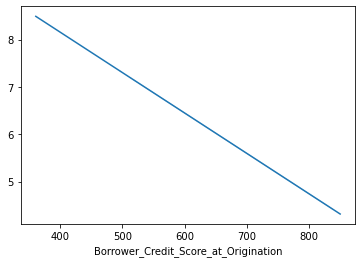

In [6]:
# plot with sm

model = sm_ols('Original_Interest_Rate ~  Borrower_Credit_Score_at_Origination ',  
               data=fannie_mae)
result = model.fit()
y_pred = result.predict()

sns.lineplot(x=fannie_mae['Borrower_Credit_Score_at_Origination'].dropna(),
            y=y_pred)

Now with sklearn.

**One difference: sklearn wants to know explicitly which values of X should be used with the coefficients from the model. So, after fitting the model, `y_pred = result.predict(X)` gets the fitted values.**


<AxesSubplot:xlabel='Borrower_Credit_Score_at_Origination', ylabel='Original_Interest_Rate'>

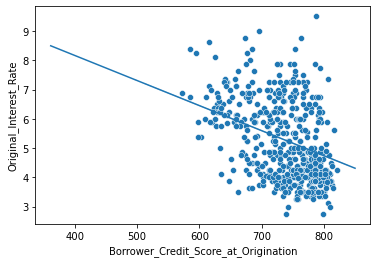

In [7]:
# plot with sklearn 

reg_data = (fannie_mae.copy() # copy to ensure we don't change the orig data
            [['const','Borrower_Credit_Score_at_Origination','Original_Interest_Rate']] 
            .dropna())
y = reg_data['Original_Interest_Rate']   # pick y
X = reg_data[['const','Borrower_Credit_Score_at_Origination']]  

model = LinearRegression()
result = model.fit(X,y)
y_pred = result.predict(X)

sns.scatterplot(x='Borrower_Credit_Score_at_Origination',
                y='Original_Interest_Rate',
                data = fannie_mae.dropna().sample(500))
sns.lineplot(x=fannie_mae['Borrower_Credit_Score_at_Origination'].dropna(),
            y=y_pred)